<a href="https://colab.research.google.com/github/ANANYA-P-iisertvm/Karate_club_dsc_assignment/blob/main/IMS24029_ANANYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1442869105.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


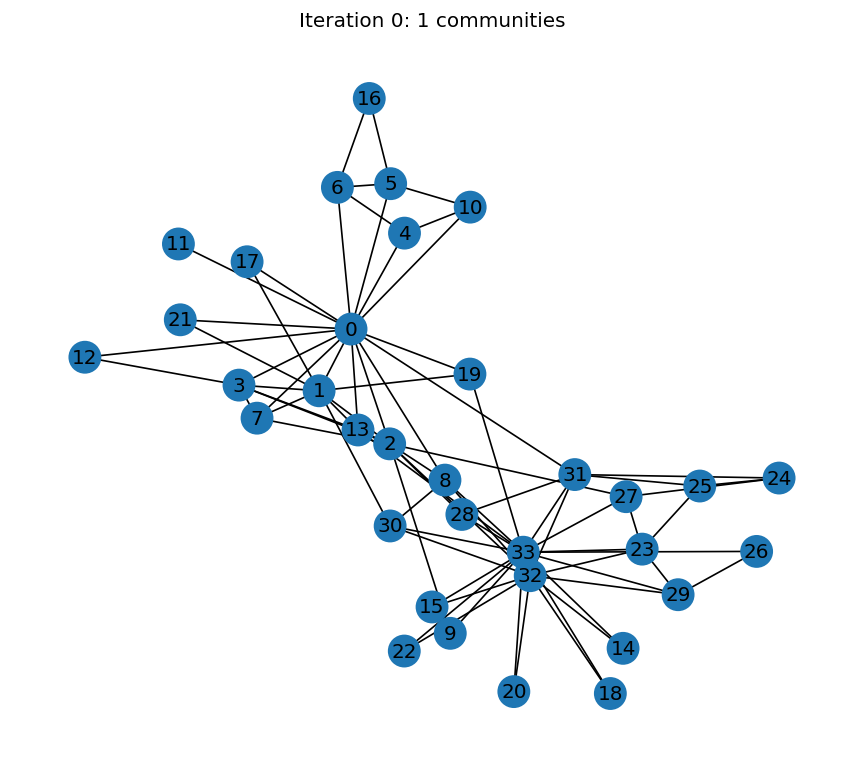

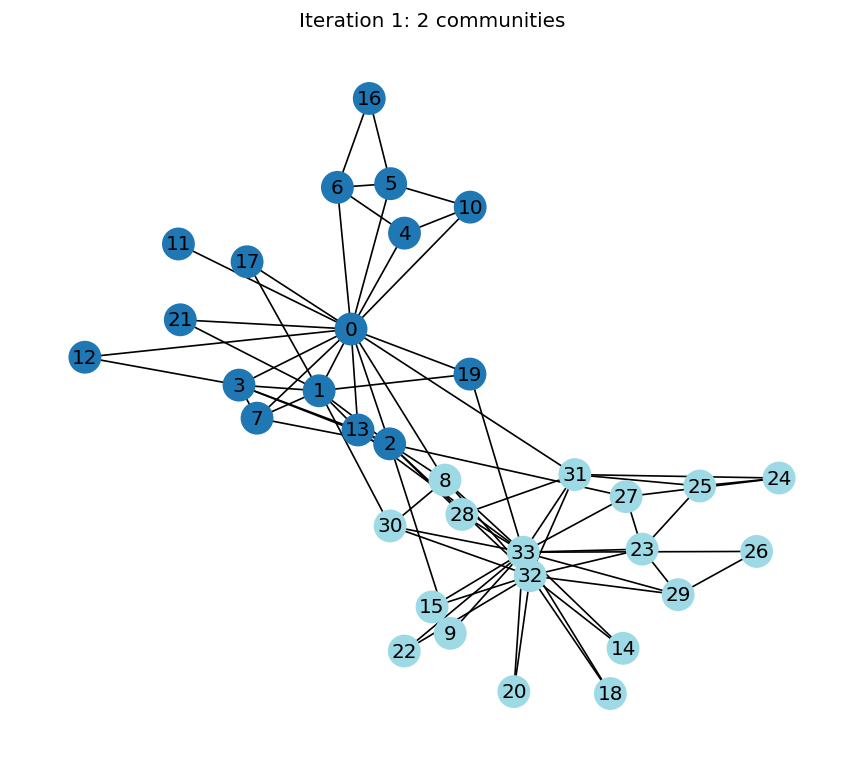

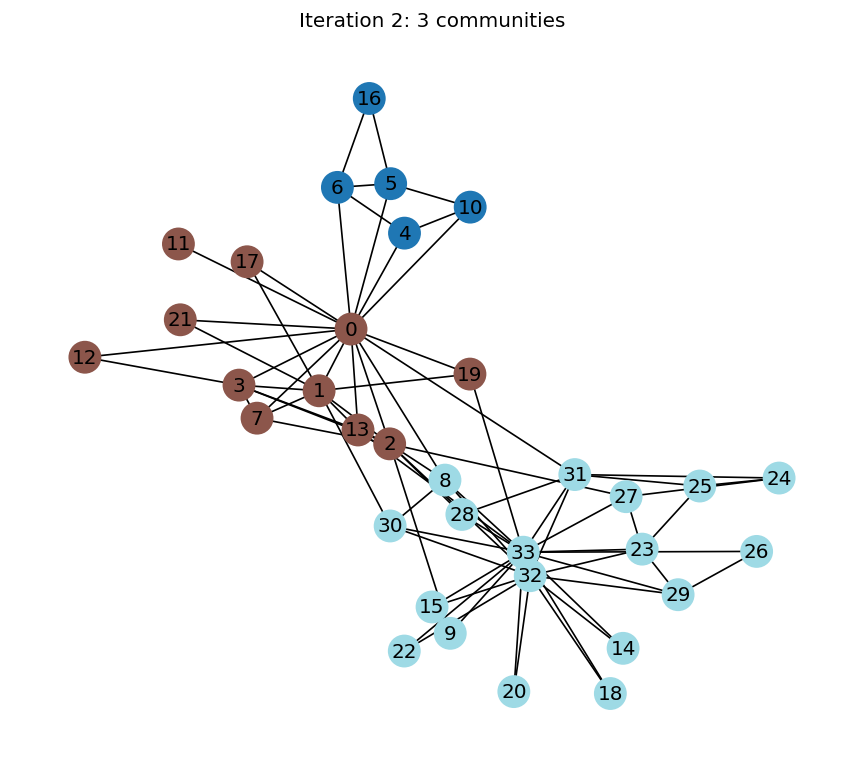

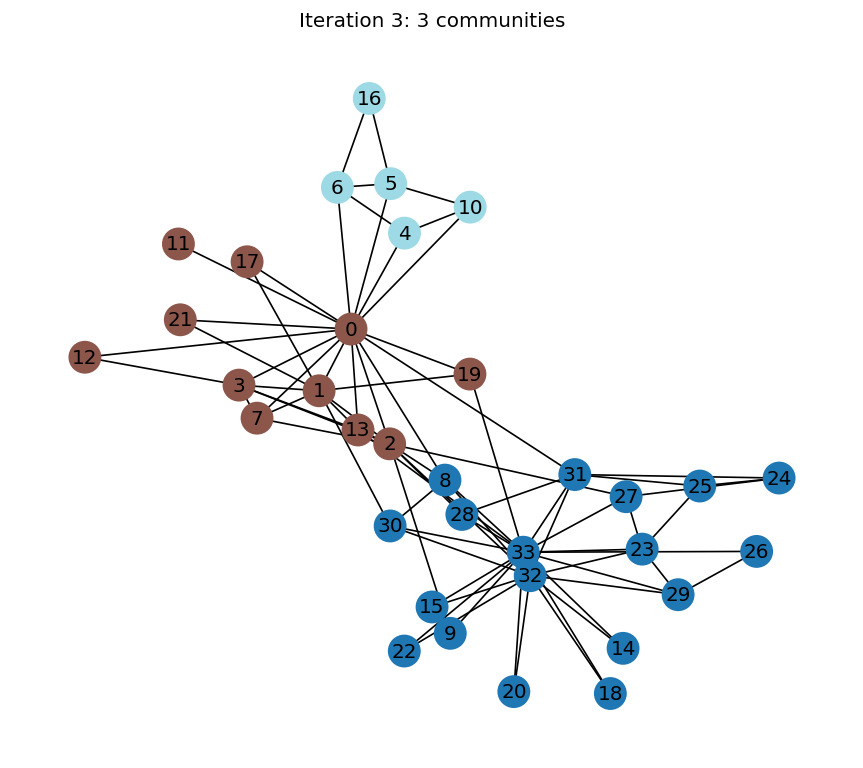


FINAL 3 COMMUNITIES:
Community 1: [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Community 2: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 3: [4, 5, 6, 10, 16]


In [42]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

FORCE_3_COMMUNITIES = True
FIXED_LAYOUT_SEED = 42
FIGSIZE = (7,6)

# setting initial graph
G = nx.karate_club_graph()
nodes_all = list(G.nodes())

A_full = nx.to_numpy_array(G, nodelist=nodes_all)
k_full = A_full.sum(axis=1)
m_full = k_full.sum() / 2.0

pos = nx.spring_layout(G, seed=FIXED_LAYOUT_SEED)

# To get modularity matrix of karate club graph
def modularity_submatrix_global(nodes_subset):
    if len(nodes_subset) == 0:
        return None
    index_map = {node:i for i,node in enumerate(nodes_all)}
    idxs = [index_map[n] for n in nodes_subset]
    A_block = A_full[np.ix_(idxs, idxs)]
    k_block = k_full[idxs]
    B = A_block - np.outer(k_block, k_block)/(2*m_full)
    return B

# To get leading eigenvector of modularity matrix
def leading_eigenpair(B):
    if B is None:
        return None, None
    vals, vecs = np.linalg.eigh(B)
    i = int(np.argmax(vals))
    return float(vals[i]), vecs[:, i]

# to compute the node metrics
def compute_metrics():
    return {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'clustering': nx.clustering(G)
    }

def plot_snapshot(communities, iteration):
    cmap = plt.cm.get_cmap("tab20")
    col = {}
    for cid, comm in enumerate(communities):
        for n in comm:
            col[n] = cid
    cols = [col[n] for n in G.nodes()]
    plt.figure(figsize=FIGSIZE)
    nx.draw(G, pos, node_color=cols, cmap=cmap, with_labels=True, node_size=350)
    plt.title(f"Iteration {iteration}: {len(communities)} communities")
    plt.axis("off")
    plt.show()

# RECURSIVE BISECTION
def spectral_bisection(force_k=None):
    queue = deque([nodes_all])
    finalized = []
    history = []
    metrics_hist = {}
    it = 0

    history.append([nodes_all])
    metrics_hist[it] = compute_metrics()
    plot_snapshot([nodes_all], it)

    while queue:
        group = queue.popleft()

        if force_k is not None:
            total_now = len(finalized) + len(queue) + 1
            if total_now >= force_k:
                finalized.append(group)
                continue

        if len(group) <= 1:
            finalized.append(group)
            continue

        B = modularity_submatrix_global(group)
        lam, u1 = leading_eigenpair(B)

        if lam is None or lam <= 0:
            finalized.append(group)
            continue

        signs = np.where(u1 >= 0, 1, -1)
        pos_group = [group[i] for i in range(len(group)) if signs[i] == 1]
        neg_group = [group[i] for i in range(len(group)) if signs[i] == -1]

        if len(pos_group)==0 or len(neg_group)==0:
            finalized.append(group)
            continue

        queue.append(pos_group)
        queue.append(neg_group)

        snapshot = list(queue) + list(finalized)
        snapshot = sorted(snapshot, key=lambda x:(len(x), min(x)))

        it += 1
        history.append(snapshot)
        metrics_hist[it] = compute_metrics()
        plot_snapshot(snapshot, it)

        if force_k is not None:
            if len(queue) + len(finalized) >= force_k:
                while queue:
                    finalized.append(queue.popleft())
                break

    final_part = finalized
    if history[-1] != final_part:
        it += 1
        history.append(final_part)
        metrics_hist[it] = compute_metrics()
        plot_snapshot(final_part, it)

    return history, metrics_hist

# -------------- RUN ----------------
history, metrics_hist = spectral_bisection(force_k=3)

final_3 = history[-1]
if len(final_3) != 3:
    final_3 = sorted(final_3, key=lambda x:-len(x))[:3]

print("\nFINAL 3 COMMUNITIES:")
for i,c in enumerate(final_3):
    print(f"Community {i+1}: {sorted(c)}")

# RECOMPUTE CENTRALITY INSIDE EACH COMMUNITY FOR EACH NODE

def compute_metrics_for_partition(communities):
    """
    For each node, compute centrality metrics on the subgraph
    induced by the community that the node belongs to.
    """
    metrics = {
        "degree": {},
        "betweenness": {},
        "closeness": {},
        "clustering": {}
    }

    for comm in communities:
        H = G.subgraph(comm)

        deg = nx.degree_centrality(H)
        bet = nx.betweenness_centrality(H, normalized=True)
        clo = nx.closeness_centrality(H)
        clu = nx.clustering(H)

        for n in comm:
            metrics["degree"][n] = deg[n]
            metrics["betweenness"][n] = bet[n]
            metrics["closeness"][n] = clo[n]
            metrics["clustering"][n] = clu[n]

    return metrics


# Build corrected metrics history
metrics_hist_comm = {}
for it, comms in enumerate(history):
    metrics_hist_comm[it] = compute_metrics_for_partition(comms)




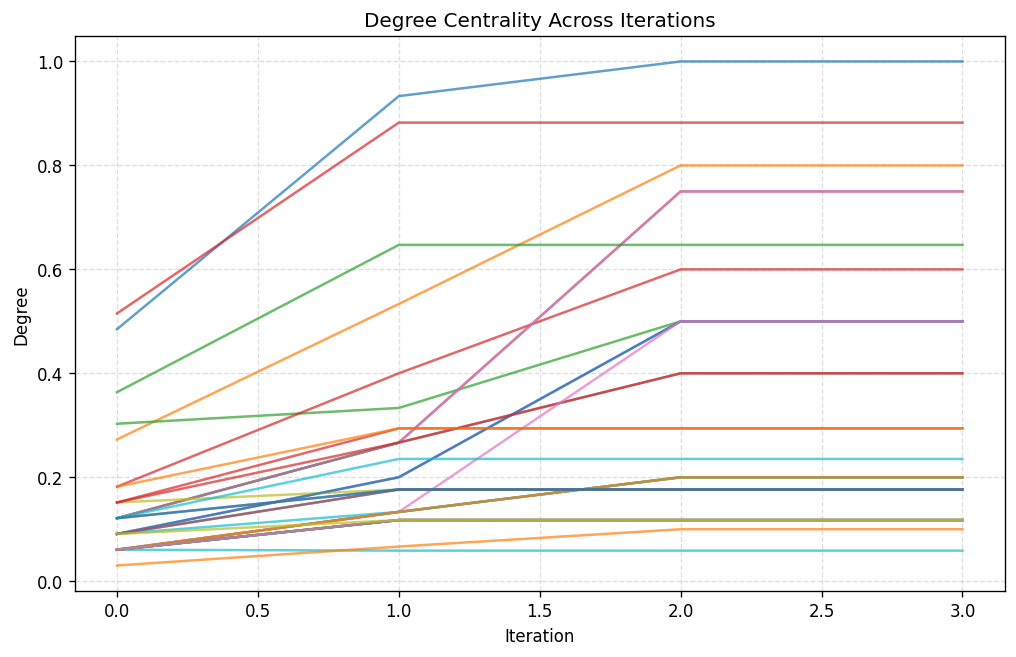

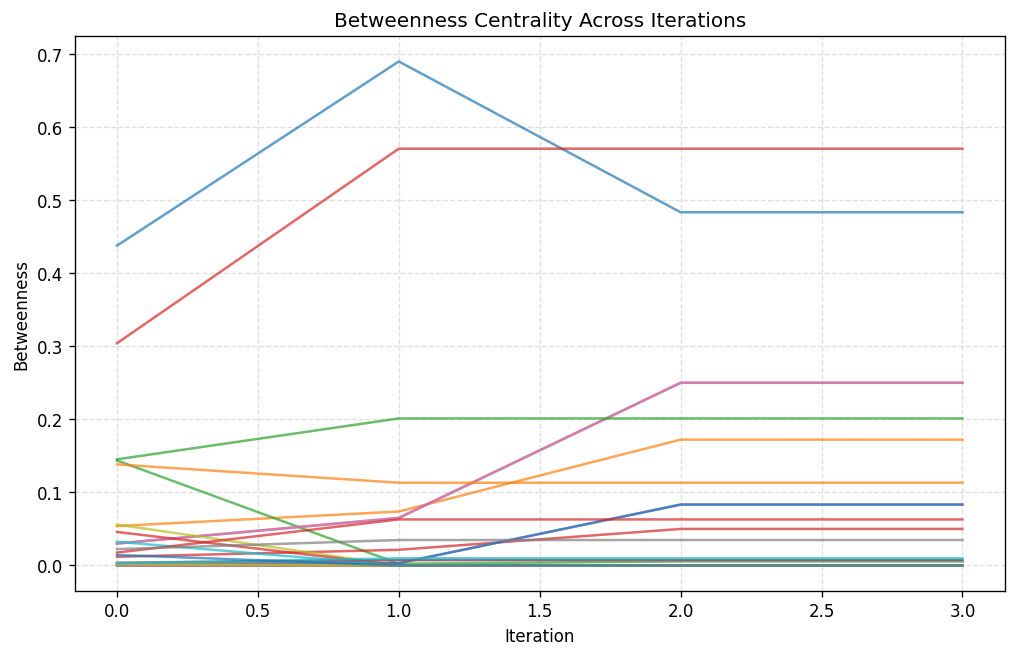

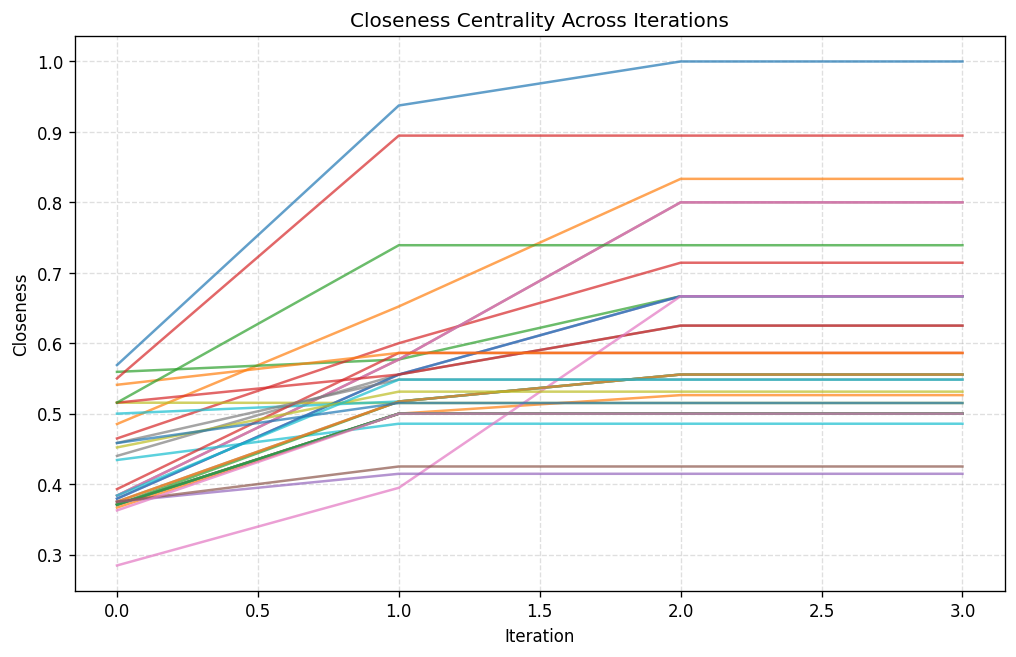

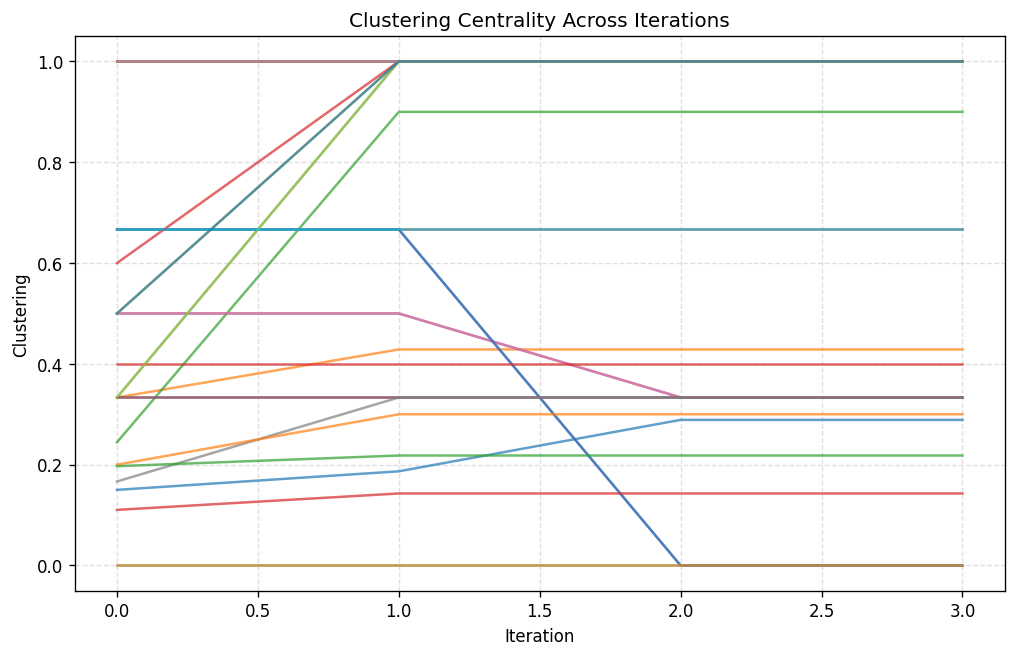

In [43]:

# PLOT CENTRALITY EVOLUTION (COMMUNITY-BASED METRICS)

def plot_centrality_over_time(metrics_hist):
    df_rows = []
    for it, metrics in metrics_hist.items():
        for node in G.nodes():
            df_rows.append({
                "iteration": it,
                "node": node,
                "degree": metrics["degree"][node],
                "betweenness": metrics["betweenness"][node],
                "closeness": metrics["closeness"][node],
                "clustering": metrics["clustering"][node],
            })

    df = pd.DataFrame(df_rows)

    def plot_metric(metric_name):
        plt.figure(figsize=(10,6))
        for node in sorted(G.nodes()):
            sub = df[df["node"] == node]
            plt.plot(sub["iteration"], sub[metric_name], alpha=0.7)
        plt.title(f"{metric_name.capitalize()} Centrality Across Iterations")
        plt.xlabel("Iteration")
        plt.ylabel(metric_name.capitalize())
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.show()

    for m in ["degree", "betweenness", "closeness", "clustering"]:
        plot_metric(m)


# ---- CALL WITH CORRECTED METRICS ----
plot_centrality_over_time(metrics_hist_comm)


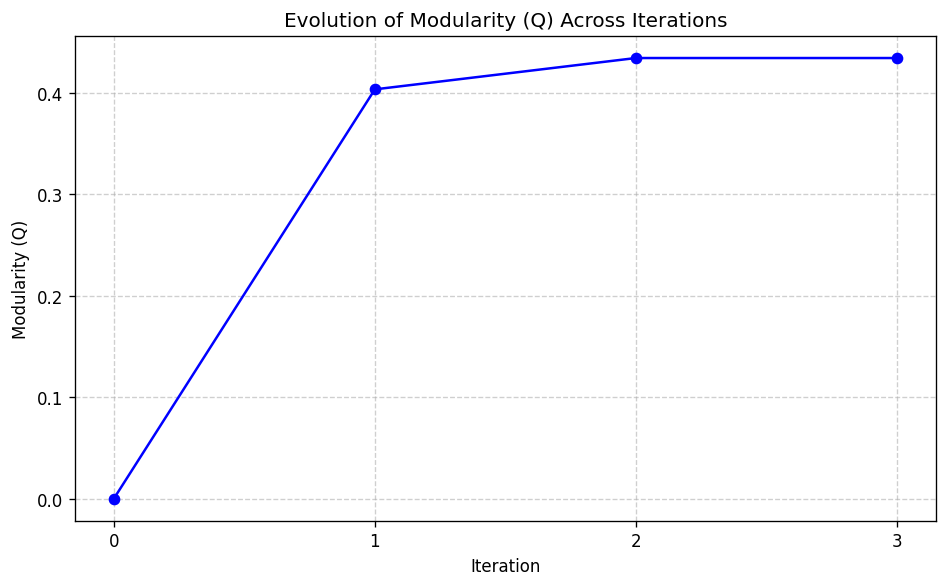

In [44]:
def compute_modularity(G, communities, nodes_all, A_full, k_full, m_full):
    """
    Computes the modularity Q for a given partition (list of communities).
    Q = (1 / (2*m_full)) * sum_c ( sum_{i,j in c} (A_ij - k_i * k_j / (2*m_full)) )
    """
    if m_full == 0:
        return 0.0

    total_modularity = 0.0
    for community in communities:
        if len(community) > 1: # Modularity contribution requires at least 2 nodes
            # B_sub is the modularity submatrix for the current community
            B_sub = modularity_submatrix_global(G, community, nodes_all, A_full, k_full, m_full)
            if B_sub is not None:
                total_modularity += np.sum(B_sub)
    return total_modularity / (2.0 * m_full)

def plot_modularity_evolution(modularity_scores, outdir):
    iterations = sorted(modularity_scores.keys())
    values = [modularity_scores[it] for it in iterations]

    plt.figure(figsize=(8, 5))
    plt.plot(iterations, values, marker='o', linestyle='-', color='blue')
    plt.xlabel("Iteration")
    plt.ylabel("Modularity (Q)")
    plt.title("Evolution of Modularity (Q) Across Iterations")
    plt.xticks(iterations)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    p = os.path.join(outdir, "modularity_evolution.png")
    plt.savefig(p, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot modularity evolution
modularity_plot_path = plot_modularity_evolution(modularity_scores,run_outdir)


Discussion :

The recursive spectral modularity partitioning produced 33 successful split(s) and stopped when no further split increased modularity.

Nodes with highest original degree ,nodes 0 and 33, tend to remain central across iterations when metrics are computed within their community subgraphs.

Degree centrality (normalized within a subgraph) often increases for nodes remaining in small communities after splits because normalization denominator decreases even if absolute degree stays the same.

Betweenness and closeness centralities are sensitive to splits: nodes acting as bridges between groups lose betweenness/closeness when those groups are separated into different communities or when the node ends up in a small cluster.

Clustering coefficient increases when a node falls into a tight triangle-rich community and decreases if it's isolated into a sparse subgroup.

Conclusion: hub nodes remain locally important, but their global bridging role can diminish as the algorithm carves dense clusters from the network.